In [1]:
%matplotlib inline

import warnings
import dotenv
import mlflow
from utils import (
    dummy,
    test_mlflow_connection,
    cross_validate,
)

MLFLOW_ENABLED = True
dotenv.load_dotenv(".env")
warnings.filterwarnings("ignore")
if MLFLOW_ENABLED:
    test_mlflow_connection()
    mlflow.set_experiment("datalab_cup01")
    mlflow.autolog(log_datasets=False)

2024/10/15 17:37:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run classy-smelt-445 at: http://10.121.252.164:5001/#/experiments/5/runs/f9d4e3a58b144f868ccfa3ecef86c957.
2024/10/15 17:37:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://10.121.252.164:5001/#/experiments/5.
2024/10/15 17:37:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [2]:
import os
import pandas as pd
import numpy as np

if not os.path.exists("./data/train.parquet"):
    df_train = pd.read_csv("./data/train.csv")
    df_train.to_parquet("./data/train.parquet")
else:
    df_train = pd.read_parquet("./data/train.parquet")
if not os.path.exists("./data/test.parquet"):
    df_test = pd.read_csv("./data/test.csv")
    df_test.to_parquet("./data/test.parquet")
else:
    df_test = pd.read_parquet("./data/test.parquet")

X_contents = df_train["Page content"].values
y = np.where(df_train["Popularity"].values > 0, 1, 0)
X_test_contents = df_test["Page content"].values

print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape:  (27643, 3)
Test data shape:  (11847, 2)


## Feature Engineering

Extracting features
Found cache, loading
Extracting features
Found cache, loading


X_info shape:  (27643, 3390)
X_test_info shape:  (11847, 3390)


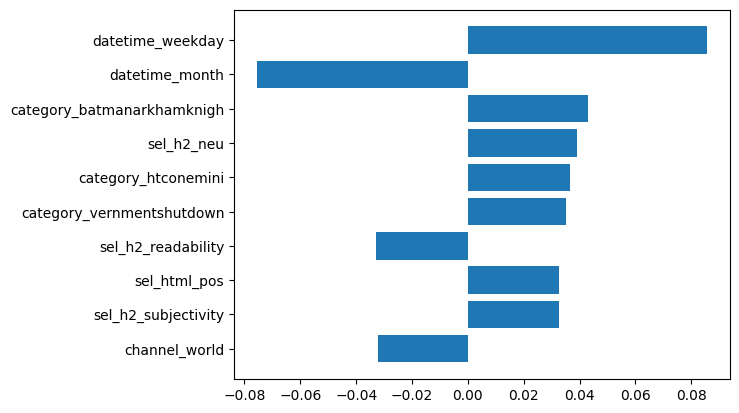

In [3]:
from features import Features
from utils.plotting import plot_correlations

features = Features(
    X_contents=X_contents,
    y=y,
    X_test_contents=X_test_contents,
    onehot_weekday=False,
    onehot_month=False,
    category_max_features=10000,
    category_train_min=3,
    category_test_min=1,
)
plot = True

features.extract_info()
X_info = features.X_info
X_test_info = features.X_test_info
print("X_info shape: ", X_info.shape)
print("X_test_info shape: ", X_test_info.shape)
if plot:
    plot_correlations(X_info, y)

X_info = X_info.fillna(X_info.mean())
X_test_info = X_test_info.fillna(X_test_info.mean())

Extractor v0.4

X_info_filtered shape:  (27643, 3337)
X_test_info_filtered shape:  (11847, 3337)


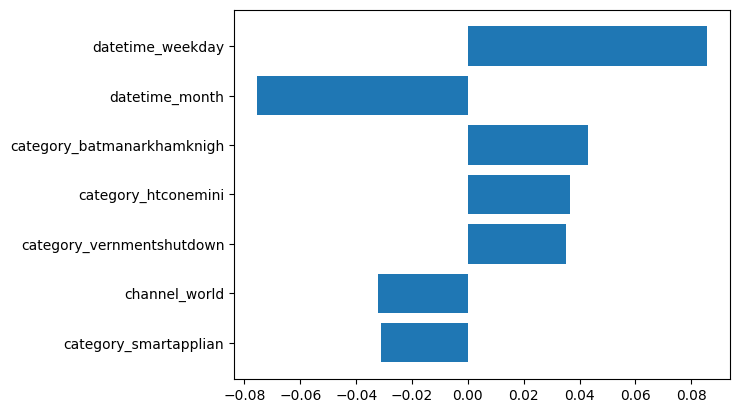

In [4]:
import re
from sklearn.preprocessing import StandardScaler

# Clone
X_info_filtered = X_info.copy()
X_test_info_filtered = X_test_info.copy()
columns = X_info_filtered.columns.tolist()

top_n_categories = True
top_n_categories_count = 50

# Filter out columns
regex_filters = [
    # r"^datetime_",  # All datetime columns
    # r"^datetime_month_",
    # r"^datetime_weekday_",
    # r"^datetime_year",
    # r"^datetime_day",
    # r"^datetime_hour",
    r"^datetime_minute",  # Overfitting
    r"^datetime_second",  # Overfitting
    r"^sel_",  # All selectors
    r"^sel_.+(?<!_token)_count$",
    r"^sel_.+(?<!_non_stop)(?<!_unique)_token_count$",
    r"^sel_.+(?<!_non_stop)_unique_token_count$",
    r"^sel_.+_non_stop_token_count$",
    r"^sel_.+_non_stop_unique_token_count$",
    # r"^sel_.+_pos$",
    # r"^sel_.+_neg$",
    # r"^sel_.+_neu$",
    r"^sel_.+_subjectivity$",
    r"^sel_.+_polarity$",
    r"^sel_.+_compound$",
    r"^sel_.+_readability$",
    # r"^sel_html_",
    # r"^sel_h1_",
    # r"^sel_h2_",
    # r"^sel_p_",
    # r"^sel_a_",
    # r"^sel_div_",
    # r"^sel_footer_a_",
    # r"^sel_section_",
    # r"^sel_instagram_",
    # r"^sel_twitter_",
    # r"^sel_img_",
    # r"^sel_iframe_",
    # r"^sel_video_",
    # r"^channel_",  # All channel columns
    # r"^category_",  # All category columns
]

# Filter columns using regex
filtered_columns = [
    col
    for col in columns
    if all([not re.match(regex, col) for regex in regex_filters])
]

X_info_filtered = X_info_filtered[filtered_columns]
X_test_info_filtered = X_test_info_filtered[filtered_columns]

if top_n_categories:
    # Get top n category columns
    category_columns = [col for col in columns if col.startswith("category_")]
    top_category_columns = (
        X_info[category_columns]
        .corrwith(pd.Series(y))
        .sort_values(
            ascending=False,
            key=lambda x: np.abs(x),
        )
        .head(top_n_categories_count)
        .index.tolist()
    )

    # Put top n category columns back
    X_info_filtered = pd.concat(
        [X_info_filtered, X_info[top_category_columns]],
        axis=1,
    )
    X_test_info_filtered = pd.concat(
        [X_test_info_filtered, X_test_info[top_category_columns]],
        axis=1,
    )

print("X_info_filtered shape: ", X_info_filtered.shape)
print("X_test_info_filtered shape: ", X_test_info_filtered.shape)
if plot:
    plot_correlations(X_info_filtered, y)

# Scale data
X = X_info_filtered.values
X_test = X_test_info_filtered.values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

## Training

In [5]:
import os
from datetime import datetime
import mlflow


def save_prediction(id, y_pred, name, mlflow_logging=True):
    df_pred = pd.DataFrame({"Id": id, "Popularity": y_pred})
    filepath = "output/minimal/{}.{}.csv".format(
        name, datetime.now().strftime("%Y%m%d-%H%M%S")
    )
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    df_pred.to_csv(filepath, index=False)
    print("Saved prediction to ", filepath)
    if mlflow_logging:
        mlflow.log_artifact(filepath, "predictions")

### Minimal Features

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into train and validation sets (for comparison purposes)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=0
)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (22114, 3337)
y_train shape:  (22114,)
X_val shape:  (5529, 3337)
y_val shape:  (5529,)
X_test shape:  (11847, 3337)


#### Logistic Regression

In [7]:
%%script false --no-raise-error

from sklearn.linear_model import LogisticRegression
import mlflow

log_params = {
    "penalty": "l2",
    "solver": "liblinear",
    "C": 0.01,
    "max_iter": 1000,
    # "n_jobs": -1, # liblinear does not support n_jobs
    "verbose": 0,
}
n_folds = 5
with mlflow.start_run(run_name="minimal-logistic-cv") as run:
    print("Run ID: ", run.info.run_id)
    mlflow.log_param("n_folds", n_folds)
    log_clf = LogisticRegression(**log_params)
    cv_results = cross_validate(log_clf, X, y, n_folds=n_folds)
    train_auc = cv_results["train_auc"].mean()
    val_auc = cv_results["val_auc"].mean()
    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("val_auc", val_auc)
    print("AUC train: {:.3f}, val: {:.3f}".format(train_auc, val_auc))

#### CatBoost

In [8]:
import os
import mlflow

mlflow.set_experiment("datalab_cup01")

cb_params = {
    "n_estimators": 1000,
    "learning_rate": 0.01,
    "depth": 6,
    "loss_function": "Logloss",
    "l2_leaf_reg": 10.0,
    "eval_metric": "AUC",
    "random_seed": 42,  # Ensures reproducibility
    "silent": True,
    "thread_count": os.cpu_count(),
}

In [9]:
%%script false --no-raise-error

import mlflow
from catboost import CatBoostClassifier

catboost_model_tags = {
    "model": "CatBoostClassifier",
    "tuning": "false",
    "final": "false",
}

n_folds = 5
with mlflow.start_run(run_name="minimal-catboost-cv") as run:
    print("Run ID: ", run.info.run_id)
    mlflow.set_tags(catboost_model_tags)
    mlflow.log_params(cb_params)
    mlflow.log_param("n_folds", n_folds)
    _cb_params = {
        **cb_params,
        "thread_count": max(os.cpu_count() // n_folds, 1),
    }
    cb_clf = CatBoostClassifier(**_cb_params)
    cv_results = cross_validate(cb_clf, X, y, n_folds=n_folds)
    train_auc = cv_results["train_auc"].mean()
    val_auc = cv_results["val_auc"].mean()
    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("val_auc", val_auc)
    print("AUC train: {:.3f}, val: {:.3f}".format(train_auc, val_auc))

In [10]:
%%script false --no-raise-error

import mlflow
import mlflow.catboost
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

cb_model_tags = {
    "model": "CatBoostClassifier",
    "tuning": "false",
    "final": "true",
}
with mlflow.start_run(run_name="minimal-catboost") as run:
    print("Run ID: ", run.info.run_id)
    mlflow.set_tags(cb_model_tags)
    for k, v in cb_params.items():
        mlflow.log_param(k, v)
    cb_clf = CatBoostClassifier(**cb_params)
    cb_clf.fit(X, y)
    mlflow.catboost.log_model(cb_clf, "model")
    train_auc = roc_auc_score(y, cb_clf.predict_proba(X)[:, 1])
    mlflow.log_metric("train_auc", train_auc)
    print("AUC train: {:.3f}".format(train_auc))

    y_test = cb_clf.predict_proba(X_test)[:, 1]
    save_prediction(df_test["Id"], y_test, "catboost")

#### XGBoost

In [11]:
import mlflow

mlflow.set_experiment("datalab_cup01")

xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "n_estimators": 200,
    "max_depth": 6,
    "learning_rate": 0.01,
    "reg_lambda": 20.0,
    "verbosity": 0,
    "n_jobs": -1,
    "random_state": 42,
}

In [12]:
%%script false --no-raise-error

import mlflow
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score

xgb_model_tags = {
    "model": "XGBClassifier",
    "tuning": "false",
    "final": "false",
}

n_folds = 5
with mlflow.start_run(
    run_name="minimal-xgboost-cv",
    tags=xgb_model_tags,
) as run:
    print("Run ID: ", run.info.run_id)
    mlflow.log_params(xgb_params)
    mlflow.log_param("n_folds", n_folds)
    xgb_clf = XGBClassifier(**xgb_params)
    cv_results = cross_validate(xgb_clf, X, y, n_folds=n_folds)
    train_auc = cv_results["train_auc"].mean()
    val_auc = cv_results["val_auc"].mean()
    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("val_auc", val_auc)
    print("AUC train: {:.3f}, val: {:.3f}".format(train_auc, val_auc))

# xgb_param_grids = {
#     "max_depth": [4, 6, 8],
#     "learning_rate": [0.005, 0.01, 0.1],
#     "n_estimators": [100, 200, 300],
# }

# xgb_model_tags = {
#     "model": "XGBClassifier",
#     "tuning": "true",
#     "final": "false",
# }

# n_folds = 5
# with mlflow.start_run(
#     run_name="minimal-xgboost-gridsearch-cv", tags=xgb_model_tags
# ) as run:
#     print("Run ID: ", run.info.run_id)
#     mlflow.log_params(xgb_param_grids)
#     mlflow.log_param("n_folds", n_folds)
#     param_grids = ParameterGrid(xgb_param_grids)
#     best_params = None
#     best_val_auc = 0
#     for params in param_grids:
#         with mlflow.start_run(
#             run_name="minimal-xgboost-child-cv",
#             nested=True,
#             tags=xgb_model_tags,
#         ) as nested_run:
#             print("Nested Run ID: ", nested_run.info.run_id)
#             _xgb_params = {**xgb_params, **params}
#             mlflow.log_params(_xgb_params)
#             xgb_clf = XGBClassifier(**_xgb_params)
#             cv_results = cross_validate(
#                 xgb_clf, X, y, n_folds=n_folds, n_jobs=n_folds, verbose=0
#             )
#             train_auc = cv_results["train_auc"].mean()
#             val_auc = cv_results["val_auc"].mean()
#             mlflow.log_metric("train_auc", train_auc)
#             mlflow.log_metric("val_auc", val_auc)
#             print("AUC train: {:.3f}, val: {:.3f}".format(train_auc, val_auc))
#             if val_auc > best_val_auc:
#                 best_val_auc = val_auc
#                 best_params = _xgb_params

#     print("Best params: ", best_params)
#     xgb_clf = XGBClassifier(**best_params)
#     xgb_clf.fit(X_train, y_train)
#     train_auc = roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1])
#     val_auc = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
#     mlflow.log_metric("train_auc", train_auc)
#     mlflow.log_metric("val_auc", val_auc)
#     print("AUC train: {:.3f}, val: {:.3f}".format(train_auc, val_auc))

In [13]:
%%script false --no-raise-error

from xgboost import XGBClassifier
import mlflow

xgb_model_tags = {
    "model": "XGBClassifier",
    "tuning": "false",
    "final": "true",
}
with mlflow.start_run(
    run_name="minimal-xgboost",
    tags=xgb_model_tags,
) as run:
    print("Run ID: ", run.info.run_id)
    for k, v in xgb_params.items():
        mlflow.log_param(k, v)
    xgb_clf = XGBClassifier(**xgb_params)
    xgb_clf.fit(X, y)
    train_auc = roc_auc_score(y, xgb_clf.predict_proba(X)[:, 1])
    mlflow.log_metric("train_auc", train_auc)
    print("AUC train: {:.3f}".format(train_auc))

    y_test = xgb_clf.predict_proba(X_test)[:, 1]

#### LightGBM

In [14]:
# %%script false --no-raise-error

lgbm_params = {
    "boosting_type": "gbdt",  # Gradient boosting decision tree
    "objective": "binary",  # Binary classification
    "metric": "auc",  # Use AUC for evaluation
    "num_leaves": 31,  # Maximum number of leaves in one tree
    "learning_rate": 0.01,
    "n_estimators": 100,
    "max_depth": 7,
    "reg_lambda": 10.0,  # Equivalent to l2 regularization
    # "random_state": 42,
    "verbosity": -1,  # Suppress excessive logs,
    "n_jobs": 6,
}

In [15]:
%%script false --no-raise-error

import mlflow
from lightgbm import LGBMClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score

mlflow.set_experiment("datalab_cup01")

lgbm_model_tags = {
    "model": "LGBMClassifier",
    "tuning": "false",
    "final": "false",
}

n_folds = 5
with mlflow.start_run(
    run_name="minimal-lightgbm-cv", tags=lgbm_model_tags
) as run:
    print("Run ID: ", run.info.run_id)
    _lgbm_params = {**lgbm_params, "n_jobs": max(os.cpu_count() // n_folds, 1)}
    mlflow.log_param("n_folds", n_folds)
    lgbm_clf = LGBMClassifier(**_lgbm_params)
    cv_results = cross_validate(lgbm_clf, X, y, n_folds=n_folds)
    train_auc = cv_results["train_auc"].mean()
    val_auc = cv_results["val_auc"].mean()
    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("val_auc", val_auc)
    print("AUC train: {:.3f}, val: {:.3f}".format(train_auc, val_auc))

# lgbm_param_grids = {
#     "n_estimators": [200, 500],
#     "num_leaves": [31, 63],
#     "max_depth": [4, 6, 8, 10],
#     "learning_rate": [0.001, 0.01, 0.1],
#     "reg_lambda": [1.0, 10.0, 20.0],
# }
# lgbm_model_tags = {
#     "model": "LGBMClassifier",
#     "tuning": "true",
#     "final": "false",
# }

# n_folds = 5
# with mlflow.start_run(
#     run_name="minimal-lightgbm-gridsearch-cv", tags=lgbm_model_tags
# ) as run:
#     print("Run ID: ", run.info.run_id)
#     mlflow.log_params(lgbm_param_grids)
#     mlflow.log_param("n_folds", n_folds)
#     param_grids = ParameterGrid(lgbm_param_grids)
#     best_params = None
#     best_val_auc = 0
#     for params in param_grids:
#         if params["max_depth"] ** 2 < params["num_leaves"]:
#             continue
#         with mlflow.start_run(
#             run_name="minimal-lightgbm-child-cv",
#             nested=True,
#             tags=lgbm_model_tags,
#         ) as nested_run:
#             print("Nested Run ID: ", nested_run.info.run_id)
#             _lgbm_params = {**lgbm_params, **params}
#             mlflow.log_params(_lgbm_params)
#             lgbm_clf = LGBMClassifier(**_lgbm_params)
#             cv_results = cross_validate(
#                 lgbm_clf, X, y, n_folds=n_folds, n_jobs=n_folds, verbose=0
#             )
#             train_auc = cv_results["train_auc"].mean()
#             val_auc = cv_results["val_auc"].mean()
#             mlflow.log_metric("train_auc", train_auc)
#             mlflow.log_metric("val_auc", val_auc)
#             print("AUC train: {:.3f}, val: {:.3f}".format(train_auc, val_auc))
#             if val_auc > best_val_auc:
#                 best_val_auc = val_auc
#                 best_params = _lgbm_params

#     print("Best params: ", best_params)
#     with mlflow.start_run(
#         run_name="minimal-lightgbm-child-best-cv",
#         nested=True,
#         tags=lgbm_model_tags,
#     ) as nested_run:
#         mlflow.log_params(best_params)
#         lgbm_clf = LGBMClassifier(**best_params)
#         lgbm_clf.fit(X_train, y_train)
#         train_auc = roc_auc_score(
#             y_train, lgbm_clf.predict_proba(X_train)[:, 1]
#         )
#         val_auc = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
#         mlflow.log_metric("train_auc", train_auc)
#         mlflow.log_metric("val_auc", val_auc)
#         print("AUC train: {:.3f}, val: {:.3f}".format(train_auc, val_auc))

#     mlflow.log_metric("train_auc", train_auc)
#     mlflow.log_metric("val_auc", val_auc)

#     lgmb_model_tags = {
#         "model": "LGBMClassifier",
#         "tuning": "false",
#         "final": "true",
#     }
#     with mlflow.start_run(
#         run_name="minimal-lightgbm", nested=True, tags=lgbm_model_tags
#     ) as nested_run:
#         lgbm_clf = LGBMClassifier(**lgbm_params)
#         lgbm_clf.fit(X, y)
#         train_auc = roc_auc_score(y, lgbm_clf.predict_proba(X)[:, 1])
#         mlflow.log_metric("train_auc", train_auc)
#         print("AUC train: {:.3f}".format(train_auc))

#         y_test = lgbm_clf.predict_proba(X_test)[:, 1]
#         save_prediction(df_test["Id"], y_test, "lightgbm")

In [16]:
%%script false --no-raise-error

import mlflow
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

lgbm_model_tags = {
    "model": "LGBMClassifier",
    "tuning": "false",
    "final": "true",
}
with mlflow.start_run(run_name="minimal-lightgbm", tags=lgbm_model_tags) as run:
    print("Run ID: ", run.info.run_id)
    lgbm_clf = LGBMClassifier(**lgbm_params)
    lgbm_clf.fit(X, y)
    train_auc = roc_auc_score(y, lgbm_clf.predict_proba(X)[:, 1])
    mlflow.log_metric("train_auc", train_auc)
    print("AUC train: {:.3f}".format(train_auc))

    y_test = lgbm_clf.predict_proba(X_test)[:, 1]
    save_prediction(df_test["Id"], y_test, "lightgbm")

#### Voting

In [ ]:
# %%script false --no-raise-error

import mlflow
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

log_params = {
    "solver": "liblinear",
    "verbose": 0,
    # "penalty": "l2",
    # "C": 0.01,
    # "max_iter": 1000,
}
rf_params = {
    "n_jobs": 4,
    # "n_estimators": 100,
    # "max_depth": 7,
}
cb_params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "silent": True,
    "thread_count": 6,
    "n_estimators": 1000,
    "learning_rate": 0.01,
    # "depth": 6,
    # "l2_leaf_reg": 10.0,
    # "random_seed": 42,  # Ensures reproducibility
}
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "verbosity": 0,
    "n_jobs": 6,
    "n_estimators": 200,
    "learning_rate": 0.1,
    # "max_depth": 4,
    "reg_lambda": 20.0,
    # "random_state": 42,
}
lgbm_params = {
    "boosting_type": "gbdt",  # Gradient boosting decision tree
    "objective": "binary",  # Binary classification
    "metric": "auc",  # Use AUC for evaluation
    "verbosity": -1,  # Suppress excessive logs,
    "n_jobs": 6,
    "num_leaves": 31,  # Maximum number of leaves in one tree
    "n_estimators": 100,
    "learning_rate": 0.01,
    # "max_depth": 10,
    "reg_lambda": 10.0,  # Equivalent to l2 regularization
    # "random_state": 42,
}

estimators = []
# estimators.append(("logistic", LogisticRegression(**log_params)))
# # estimators.append(("random_forest", RandomForestClassifier(**rf_params)))
# estimators.append(("catboost", CatBoostClassifier(**cb_params)))
# estimators.append(("xgboost", XGBClassifier(**xgb_params)))
# estimators.append(("lightgbm", LGBMClassifier(**lgbm_params)))
estimators.append(("xgboost1", XGBClassifier(**xgb_params)))
estimators.append(("xgboost2", XGBClassifier(**xgb_params)))
estimators.append(("xgboost3", XGBClassifier(**xgb_params)))
estimators.append(("lightgbm1", LGBMClassifier(**lgbm_params)))
estimators.append(("lightgbm2", LGBMClassifier(**lgbm_params)))
estimators.append(("lightgbm3", LGBMClassifier(**lgbm_params)))

# Train a voting classifier
voting_clf = VotingClassifier(
    estimators=estimators,
    voting="soft",
    n_jobs=-1,
)
voting_model_tags = {
    "model": "VotingClassifier",
    "tuning": "false",
    "final": "false",
}

n_folds = 5
with mlflow.start_run(
    run_name="minimal-voting-cv", tags=voting_model_tags
) as run:
    mlflow.log_param("n_folds", n_folds)
    cv_results = cross_validate(voting_clf, X, y, n_folds=n_folds)
    train_auc = cv_results["train_auc"].mean()
    val_auc = cv_results["val_auc"].mean()
    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("val_auc", val_auc)
    print("AUC train: {:.3f}, val: {:.3f}".format(train_auc, val_auc))
    print("Run ID: ", run.info.run_id)

Running 5-fold cross-validation


In [ ]:
# %%script false --no-raise-error

import mlflow
from sklearn.metrics import roc_auc_score

voting_model_tags = {
    "model": "VotingClassifier",
    "tuning": "false",
    "final": "true",
}

with mlflow.start_run(
    run_name="minimal-voting", tags=voting_model_tags
) as run:
    voting_clf.fit(X, y)
    train_auc = roc_auc_score(y, voting_clf.predict_proba(X)[:, 1])
    mlflow.log_metric("train_auc", train_auc)
    print("AUC train: {:.3f}".format(train_auc))
    print("Run ID: ", run.info.run_id)

    y_test = voting_clf.predict_proba(X_test)[:, 1]
    save_prediction(df_test["Id"], y_test, "voting")